<a href="https://colab.research.google.com/github/MJAHMADEE/Industrial_Control_Course/blob/main/PID_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Industrial Control (PID World)**

# 4.0 PID Control

Proportional-Integral-Derivative (PID) control is a workhorse of modern engineering. Orginally developed in the 1920's for the automatic steering of ships, the technology eventually found its way to the process industries following publication of _Principles and Practice of Automatic Control_ for the British trade magazine _The Engineer_ in 1937. The publication of this paper kicked off a period of rapid innovation in which instrument makers developed the equipment to put these ideas into practice, and the process industries adopted these new technologies.

In this series of notebooks we will review the basic formulations of PID control, issues that arise and how they are managed, and develop a basic implementation. Our goal here is to provide with the knowledge needed to understand the principles of PID control, how to put the technology to work, and how to recognize and troubleshoot issues arising in practice.

## 4.0.1 PID Control Formulations

### 4.0.1.1 Non-interacting Form

A typical mathematical formulation known as the **non-interacting form** of PID control can be written

\begin{align}
MV & = \overline{MV} + K_P \left(SP - PV\right) + K_I\int_0^t (SP - PV)\ dt' + K_D\frac{d(SP - PV)}{dt}
\end{align}

where we use the generic notation $MV$ to denote the manipulated variable, and $PV$ the process variable to be controlled to the desired setpoint value $SP$. $\overline{MV}$ denotes a nominal or reference value of the manipulated variable. The remaining terms on the right hand side are prescription of how to adjust the manipulated variable in response to a deviation of the process variable for the desired setpoint value.

In this formulation there are three coefficients, $K_P$, $K_I$, and $K_D$ denoting the relative contributions of the **proportional**, **integral**, and **derivative** terms to the control action.  These constants can be adjusted to achieve a useful closed-loop dynamics.

### 4.0.1.2 ISA Form

Another commmon formulation (sometimes also called the **ideal**, or **additive* form) is given by

\begin{align}
MV & = \overline{MV} + K_c \left[ \left(SP - PV\right) + \frac{1}{\tau_I}\int_0^t (SP - PV)\ dt' + \tau_D\frac{d(SP - PV)}{dt}
\right]\end{align}

For the purposes of control, this form has the same functionality of the non-interacting form but with a different set of parameters. The constant $K_c$ is called the **control gain**, $\tau_I$ the **integral time constant**, and $\tau_D$ the **derivative time constant**. 

Comparing these two forms of PID control shows they are identical under a conversion of parameters. Going from ISA to non-interacting form

\begin{align}
K_P & = K_c \\
K_I & = \frac{K_c}{\tau_I} \\
K_D & = K_c\tau_D
\end{align}

or from non-interacting to ISA form

\begin{align}
K_c & = K_P \\
\tau_I & = \frac{K_P}{K_I} \\
\tau_D & = \frac{K_D}{K_P}
\end{align}

## 4.0.2 Implementation

In these notebooks we'll proceed through a series of PID control implementations. These are intended to demonstrate key features of the control algorithm, and issues that arise in practice. Since these implementations are for demonstration only, we'll keep them as simple and straightforward as possible.

# 4.1 Implementing PID Controllers with Python Yield Statement

Up to this point we have been implementing simple control strategies where the manipulated variable depends only on current values of the process variable and setpoint. Relay control, for example, can be expressed mathematically as

$$MV = Kp (SP - PV)$$

and implemented in Python as

    def proportional(PV, SP):
        MV = Kp * (SP - PV)
        return MV

Python functions carry no persistent memory from one use to the next, which is fine if the control algorithm requires no knowledge of the past.

The problem, however, is that PID control requires use of past measurements. Proportional-integral control, for example, tracks the cumulative sum of the differences between setpoint and the process variable. Because a Python function disappears completely after the return statement, the value of the cumulative sum must be stored somewhere else in code. The coding problem is to figure out how and where to store that information between calls to the algorithm. We seek coding methods that encapsulate the state of control algorithms.

There are several ways persistence can be provided in Python (roughly in order of increasing capability and complexity):

* Generators written using the Python `yield` statement
* Classes
* Asynchronous programming with co-routines
* Threads

Classes, in particular, are a tool for encapsulating data and functionality within a single software entity. Classes are widely used in Python programming, and should eventually become part of every Python programmer's toolkit.

As we demonstrate below, however, the Python `yield` statement is often sufficient to write self-contained implementations of control algorithm. 

## 4.1.1 Python Yield Statement

The cells below provide a very brief introduction to Python `yield` statement. More information can be found [here](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/)

A function incorporating a `yield` statement creates a persistent object called a generator.  Like the `return` statement, `yield` says to return a value and control to the calling routine. Unlike the `return` statement, however, the generator goes into a suspended state following the `yield`. On the next use it will pick up execution right where execution left off.

Here's an example produces a generator for four numbers.

In [ ]:
def numbers_gen():
    yield 0
    yield 1
    yield 2.7182818
    yield 3.1415926

To use this, first create the actual generator object that will do the work. 

In [ ]:
numbers = numbers_gen()

There are several ways to get values from a generator. One way is using the `next()` function which executes generator until the next `yield` statement is encountered, then return the value.

In [ ]:
print(next(numbers))
print(next(numbers))
print(next(numbers))
print(next(numbers))

0
1
2.7182818
3.1415926


The generator object `numbers` has a `send` method for sending information to the generator and causing it to execute until the next `yield`.  For this case all we need to send is `None`.

In [ ]:
numbers = numbers_gen()
print(numbers.send(None))
print(numbers.send(None))
print(numbers.send(None))
print(numbers.send(None))

0
1
2.7182818
3.1415926


The `send` method provides two-way communication with a generator. Here's an example of how that works.

In [ ]:
def texter_gen():
    a = yield "Started"
    b = yield a
    yield b

In [ ]:
texter = texter_gen()
print(texter.send(None))
print(texter.send("Hello, World"))
print(texter.send("Go Irish"))

Started
Hello, World
Go Irish


There's a subtle detail here that easy to miss. The first `send` starts the generator which then executes up to the first yield statement. At that point execution halts and the message "Started" is sent to the calling routine. The second `send` causes execution to pick up again and puts the message "Hello, World" into variable `a`.  

An important point is that the first `send` to a generator must always be `None`.

In the next example `yield` is placed inside an infinite loop. This function creates generators that return the square of the number sent.

In [ ]:
# A function that will create generators
def our_numbers():
    n = 0
    while True:
        n = yield n*n

In [ ]:
# create a generator
numbers = our_numbers()

# start the generator
numbers.send(None)        

# send values to the generator and print the results
print(numbers.send(4))
print(numbers.send(12))
print(numbers.send(42))

# how to remove a generator when finished using it.
numbers.close()

16
144
1764


Let's now consider how generators may be used for process control applications. The next cell defines a function that will create generators that perform as proportional controllers with specified gain $K_p$ and setpoint $SP$. When sent a current value of the process variable `PV`, the controllers will return a value for the manipulated variable `MV`.

In [ ]:
def proportional(Kp, SP):
    """Creates proportional controllers with specified gain and setpoint."""
    MV = 0
    while True:
        PV = yield MV
        MV = Kp * (SP - PV)

Let's create and initialize two controllers with the same setpoint but different gains.

In [ ]:
controller1 = proportional(10, 40)
controller1.send(None)

controller2 = proportional(1, 40)
controller2.send(None)

0

Let's see how these controllers would respond to a PV value of 35.

In [ ]:
PV = 35

print("Controller 1: MV = ", controller1.send(PV))
print("Controller 2: MV = ", controller2.send(PV))

Controller 1: MV =  50
Controller 2: MV =  5


This is a important feature from a coding and maintenance perspective. We need to create and maintain only one copy of the control algorithm.

## 4.1.2 PID Control Implementation

A simple form of Proportional-Integral control is an example of a controller with internal state. In velocity form,

\begin{align}
MV_k & = \overline{MV} + K_P e_k  + K_I \sum_{k'=0}^k e_{k'}(t_k - t_{k-1}) + K_D \frac{e_k - e_{k-1}}{t_k - t_{k-1}}
\end{align}

where $e_k$ is the difference between setpoint and measured process variable

\begin{align}
e_k = SP_k - PV_k
\end{align}

$K_P$, $K_I$, and $K_D$ are control constants, and $t_k$ is the sampling time. 

The following cell provides a direct implementation of this algorithm as a Python generator.

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0):
    # initialize stored data
    e_prev = 0
    t_prev = -100
    I = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, PV, SP
        t, PV, SP = yield MV
        
        # PID calculations
        e = SP - PV
        
        P = Kp*e
        I = I + Ki*e*(t - t_prev)
        D = Kd*(e - e_prev)/(t - t_prev)
        
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        e_prev = e
        t_prev = t

## 4.1.3 Simulation

Let's see how well this PID implementation works. We'll perform the simulation with a setpoint that starts at room temperature, then rises to 50°C at $t = 50$ seconds. The data historian will record values of the setpoint, process variable, computed manipulated variable, and the actual value of the manipulated variable.

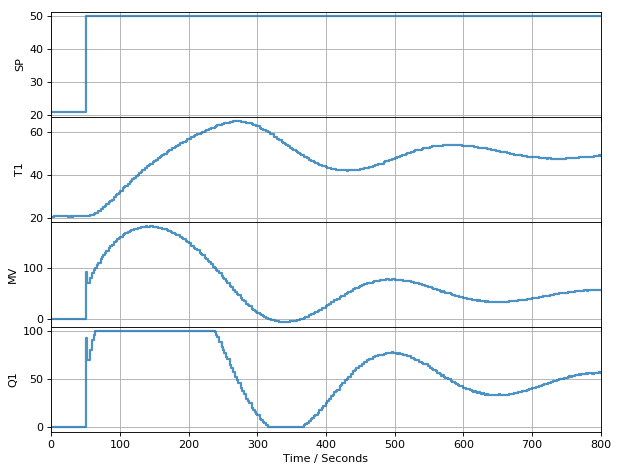

TCLab Model disconnected successfully.


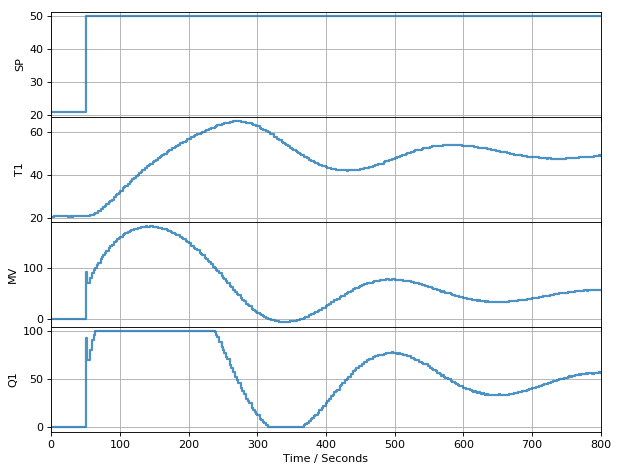

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2)        # create pid control
controller.send(None)              # initialize

tfinal = 800

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50           # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)                         # update information display

## 4.1.4 Analysis

The good news is that the controller did steer the heater to the desired setpoint. There was some overshoot and undershoot along the way, but eventually the system did get there.

In examining the response more closely, however, we can see at least two issues that must be addressed before this control algorithm could be applied to large scale indusrial control:

1. A sudden adn abrubt "kick" to the manipulated variable when the setpoint changes.
2. A mismatch between computed and actually feasible control actions.

# 4.2 PID Control with Setpoint Weighting

## 4.2.1 Setpoint 'Kick'

Our standard form for PID control has been

\begin{align}
MV & = \overline{MV} + K_P (SP - PV) + K_I\int_0^t (SP - PV)\ dt' + K_D\frac{d(SP - PV)}{dt}
\end{align}

Our initial implementation of PID control uncovered an issue with this formula  when there are sudden changes to the setpoint $SP$. The issue is most obvious in the derivative term where

\begin{align}
K_D\frac{d(SP - PV)}{dt} & \longrightarrow \infty
\end{align}

for a step change in setpoint. The issue is also evident in the proportional term $K_P (SP - PV)$ which undergoes a step change in value. In process control applications, a step change in the manipulated variable may require sudden and abrupt changes in valve position, process flows, or pressures, all of which can cause significant strain on very large devices.

This phenomenon is called **setpoint kick** (or sometimes **derivative kick**) which is generally to be avoided.

## 4.2.2 Setpoint Weighting

The most common remedy is to introduce setpoint weighting. To this end, the PID control formula is written 

\begin{align}
MV & = \overline{MV} + K_P e_P + K_I\int_0^t e_I\ dt' + K_D\frac{de_D}{dt}
\end{align}

where the error terms are given by

\begin{align*}
e_P(t) & = \beta\ SP - PV \\
e_I(t) & = SP - PV \\
e_D(t) & = \gamma\ SP - PV
\end{align*}

The effect is to introduce a different error term for each term in the control equation. The integral term remains the same as before, which is necessary in order to force the process variable $PV$ to be equal to the setpoint $SP$ at steady-state. The error terms for the proportional and derivative terms, however, include constants $\beta$ and $\gamma$ which are used to modify the response to setpoint changes.

Common practice is to set $\gamma = 0$ which entirely eliminates derivative action based on change in the setpoint. When incorporated in PID control, this feature is sometimes called **derivative on output**. This almost always a good idea in process control because it eliminates the 'derivative kick' associated with a quick change in setpoint.

In practice, the term $\beta$ is generally tuned to meet the specific application requirements. In this case, where setpoint tracking is not a high priority, setting $\beta = 0$ is a reasonable starting point.

## 4.2.3 Implementation of Setpoint Weighting

The implementation of setpoint weighting is straightforward. The object definition is modified to include additional parameters `beta` and `gamma` with typical default values. Error terms for the proportional and derivative terms are computed explicitly, and in the case of the derivative also saved for the next time step.

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    I = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV
        t, PV, SP = yield MV
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

## 4.2.4 Simulation

Let's see how well this PID implementation works. We'll perform the simulation with a setpoint that starts at room temperature, then rises to 50°C at $t = 50$ seconds. The data historian will record values of the setpoint, process variable, computed manipulated variable, and the actual value of the manipulated variable.

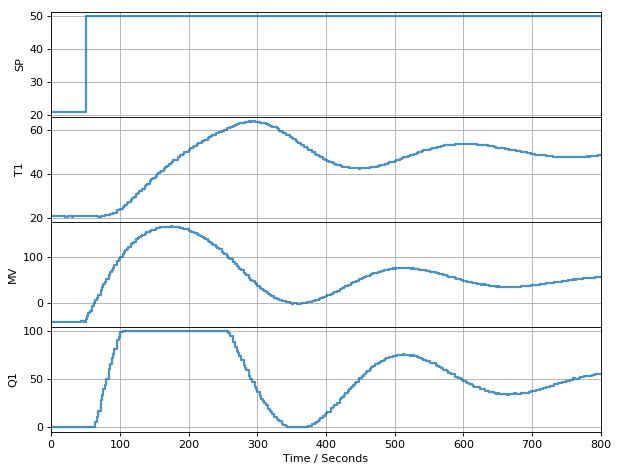

TCLab Model disconnected successfully.


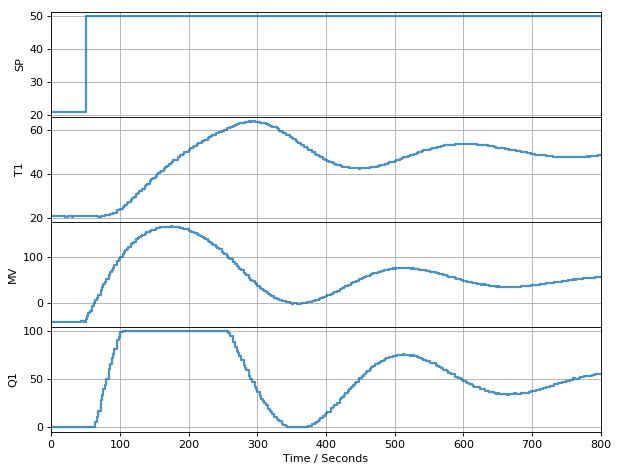

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 800

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50           # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)                         # update information display

# 4.3 PID Control with Bumpless Transfer

## 4.3.1 Switching from Manual to Automatic Control

The following cells simulate a common situation where a system is manually controlled to a desired steady state, then a controller turned on to maintain that state without further operator intervention. Examples include a pilot switching to autopilot of an aircraft at cruising altititude, or a car driver turning on cruise-control once at a desired highway driving speed.

For this simulation we use PID control with setpoint weighting.

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    I = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV
        t, SP, PV = yield MV
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

The desired setpoint is 50°C which is acheived with a power setting of approximately 50%.  We'll start out at the power setting for a period of 400 seconds, then turn on the controller.

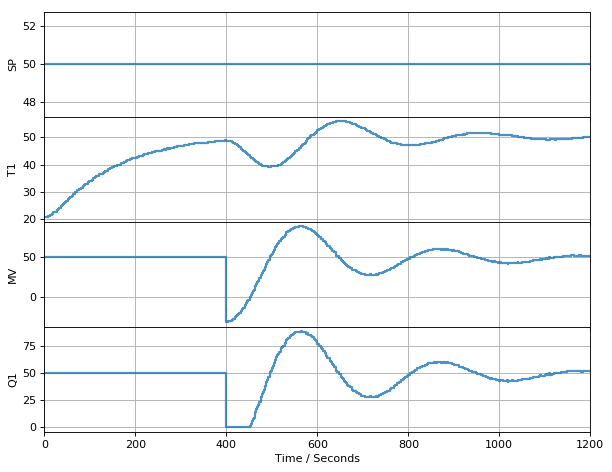

TCLab Model disconnected successfully.


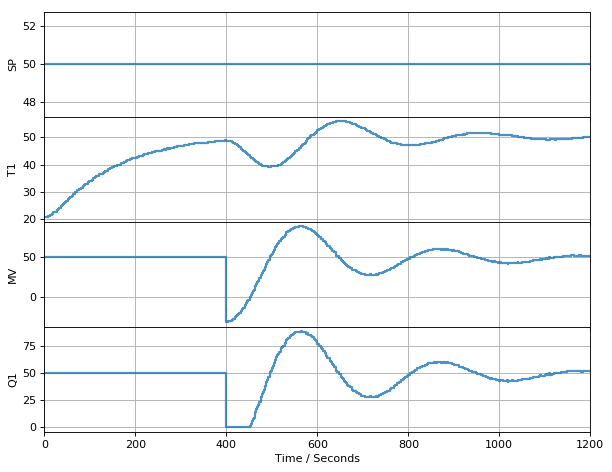

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200
SP = 50

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1                            # get measurement
        if t < 400:                            # choice between manual and auto control
            MV = 50
        else:
            MV = controller.send([t, SP, PV])
        lab.U1 = MV                            # apply 
        p.update(t)                            # update information display

## 4.3.2 Bumpless Transfer

The previous simulation would be a genuine problem for most process operators. You have a controller that can do the job but there is no acceptable way to turn it on. Can you imagine if this happen each time a pilot turned on an autopilot, or a driver turn on cruise control?

What we need is a property called **bumpless transfer**.  Bumpless transfer is a control feature that minimizes any disturbances encountered on the transition from manual to automatic operation.

There are actually three elements bumpless transfer.

1. Get the controller output to track the manipulated variable.
2. Setpoint tracks the process variable during manual control.
3. Start at or near a steady state.

### 4.3.2.1 Tracking the Manipulated Variable

As we've seen in previous simulations, the output of the controller might not match the actual value applied to the process.  In the simulations this was due to controller output exceeding the physical limits of the manipulated variable. In the case of bumpless transfer, the cause is due to the manual adjustment of the manipulated variable. 

To address this issue, we add a new input to the controller called **tracking**. The controller will then attempt to maintain the output value of the manipulated variable equal to the tracking input. This will turn out to provide a number of useful properties.

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        t, PV, SP, TR = yield MV
        
        # adjust I term so output matches tracking input
        I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

The implementation code also changes. In effect, the controller is always on, even if the input to process is under manual control. In `manual` mode, the controller is monitoring and tracking the manipulated variable, and always ready to take over when switched to automatic control.

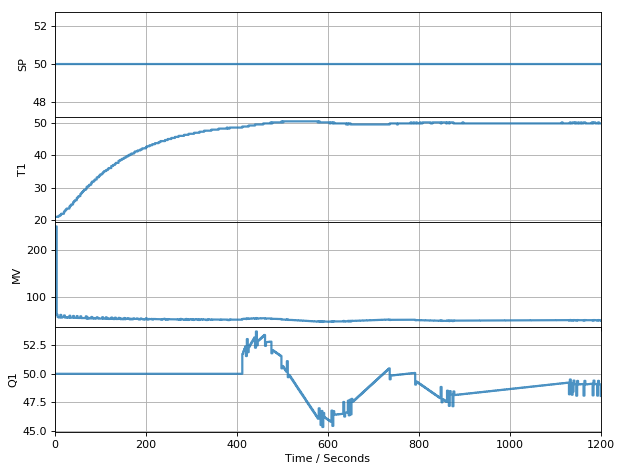

TCLab Model disconnected successfully.


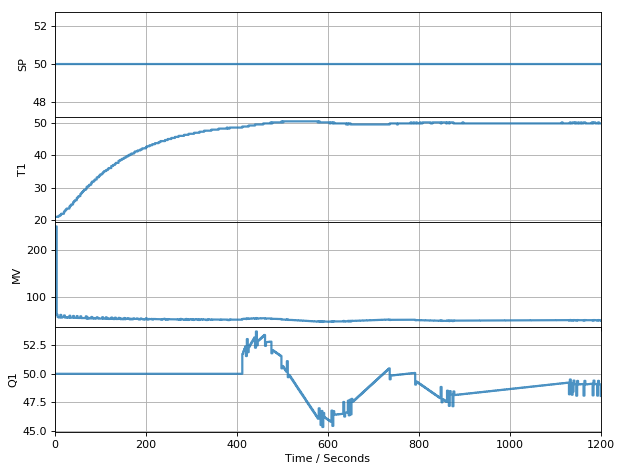

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200
SP = 50

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1                            # get measurement
        MV = controller.send([t, PV, SP, lab.Q1()])
        if t < 400:
            lab.U1 = 50
        else:
            lab.U1 = MV                        # compute control action
        p.update(t)                            # update information display

### 4.3.2.2 Setpoint Tracking

A second component of bumpless transfer is to have the setpoint track the process variable.  This is generally what we do in automotive cruise control when we push the `set` button.

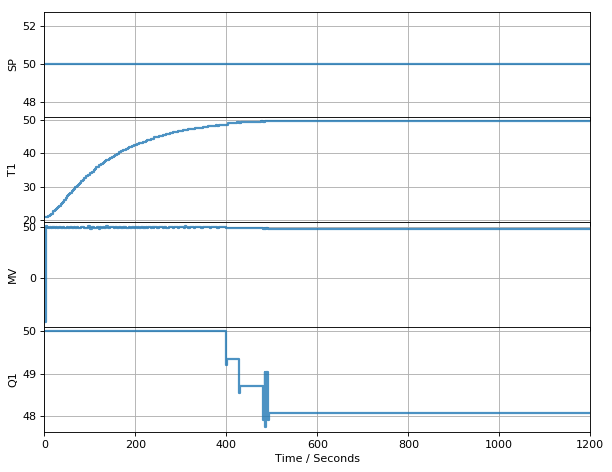

TCLab Model disconnected successfully.


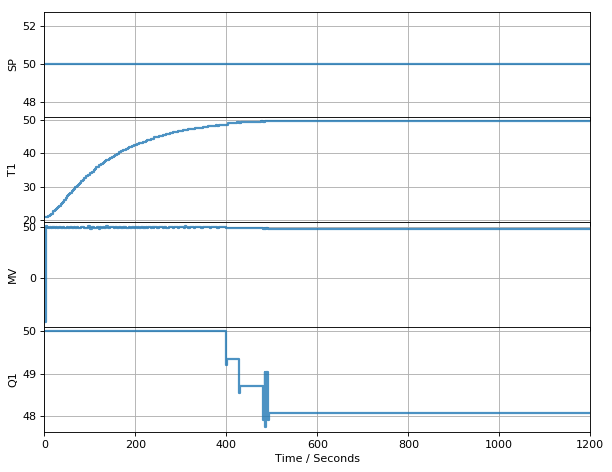

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200
SP = 50

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1                            # get measurement
        MV = controller.send([t, PV, PV, lab.Q1()])
        if t < 400:
            lab.U1 = 50
        else:
            lab.U1 = MV                        # compute control action
        p.update(t)                            # update information display

### 4.3.2.3 Steady State

The final condition to assure bumpless transfer is to at or very near to a steady state. To demonsrate, we will repeat the last simulation, except execute the manual to auto transition at $t$ = 600 seconds.

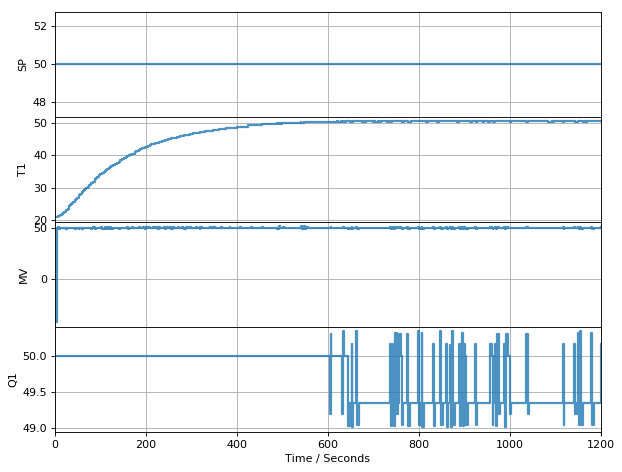

TCLab Model disconnected successfully.


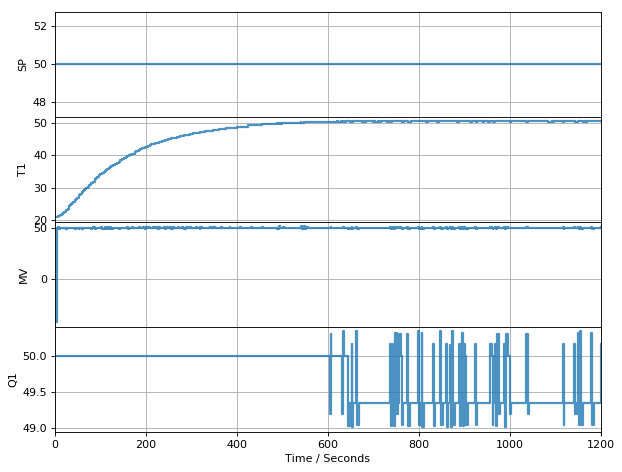

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200
SP = 50

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1                            # get measurement
        MV = controller.send([t, PV, PV, lab.Q1()])
        if t < 600:
            lab.U1 = 50
        else:
            lab.U1 = MV                        # compute control action
        p.update(t)                            # update information display

# 4.4 PID Control with Anti-Reset-Windup

## 4.4.1 Additional Benefits of Tracking the Manipulated Variable

An extra **tracking** input was added in order to improve response when switching from manual to automatic control. This turns out to have additional benefits for the case where the controller would otherwise be requesting infeasible values for the manipulated variable.

The next simulation simply repeats the applies the tracking controller to the heater startup case.

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        t, PV, SP, TR = yield MV
        
        # adjust I term so output matches tracking input
        I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

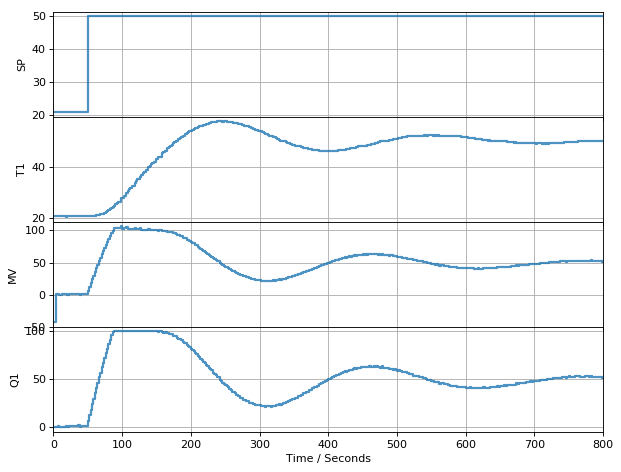

TCLab Model disconnected successfully.


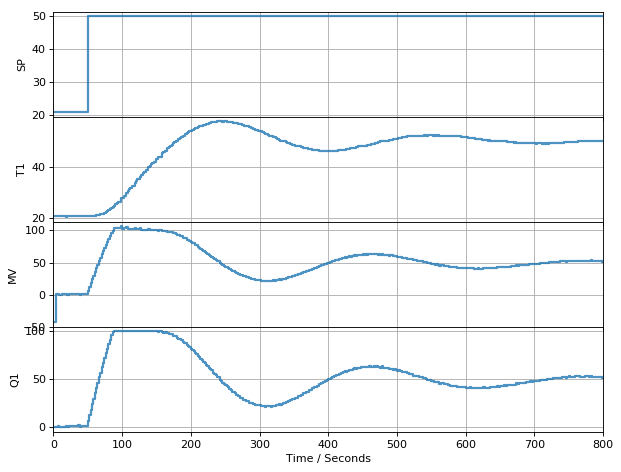

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 800

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50                     # get setpoint
        PV = lab.T1                                   # get measurement
        MV = controller.send([t, PV, SP, lab.Q1()])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display

We observe markedly improved performance with less overshoot of the setpoint, less undershoot, and faster settling time.  

The reason for the improved response is that the integral term of the PID controller is constrained such that the manipulated variable remains within feasible limits. This important feature is called **anti-reset windup**.

## 4.4.2 Embedding Anti-Reset Windup inside the Controller

The most common reason for a mismatch between the controller output and the actual value of the manipulated variable are the existence of hard limits on $MV$.  These hard limits can be enforced inside of the control algorithm which may, for some applications, eliminate the need for using the **tracking** input.

The next cell modifies our control algorithm to accomodate this feature, and automatically detects if a tracking signal is passed to the controller.

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, PV, SP = data
        else:
            t, PV, SP, TR = data
            I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        #I = MV - MV_bar - P - D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

This version of the control is tested again with our startup example, but this time without using the tracking input to the controller. The results demonstrate the importance of anti-reset windup.

In [ ]:
550 % 100

50

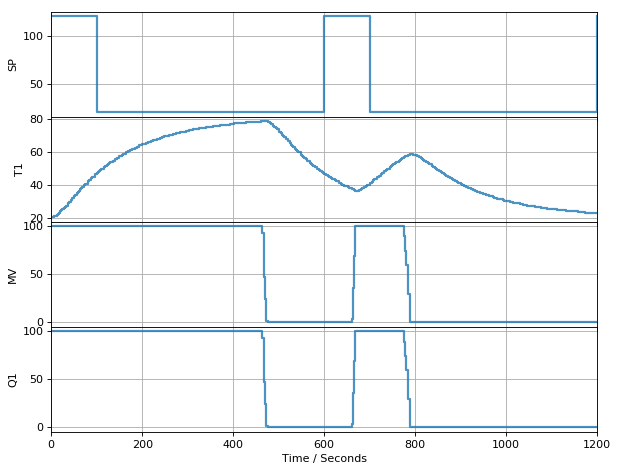

TCLab Model disconnected successfully.


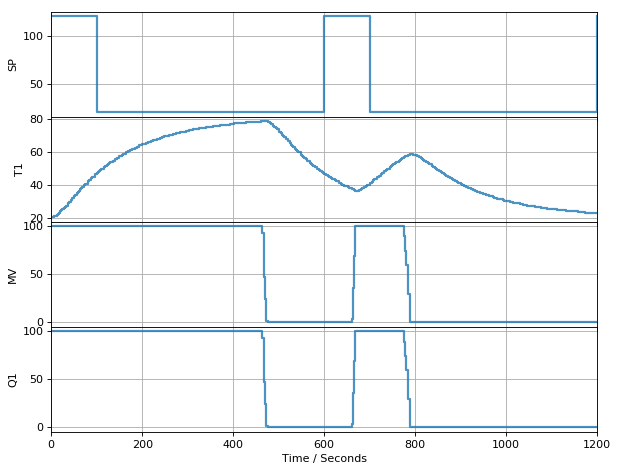

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(1, 0.2, 0, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    Tlo = lab.T1
    Thi = 120
    for t in clock(tfinal, 2):
        SP =  Thi if (t % 600 < 100) else Tlo                    # get setpoint
        PV = lab.T1                                   # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display

In [ ]:
h.columns

['Time', 'SP', 'T1', 'MV', 'Q1']

# 4.5 Realizable PID Control

The next part that needs attention is the derivative control term which is currently implemented as

\begin{align}
D & = K_D\frac{de^D}{dt} \approx K_D\frac{e^D_k - e^D_{k-1}}{t_k - t_{k-1}}
\end{align}

where is a weighted difference between the setpoing and process variable $e^D = \gamma SP - PV$.

This term clearly presents problems as the control sampling period gets small. Any difference between $e^D_k$ and $e^D_{k-1}$ due to measurement noise, for example, will be magnified when divided by the small difference between $t_k$ and $t_{k-1}$.

## 4.5.1 Example: PID Control with Significant Measurement Noise

Here we start with the PID control algorithm that implements setpoint weighting and anti-reset windup. 

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, PV, SP = data
        else:
            t, PV, SP, TR = data
            I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        I = MV - MV_bar - P - D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

We modify the control problem by introducing a signficant degree of measurement noise.

\begin{align}
T^{meas}_{1,k} & = T_{1,k} + e_k
\end{align}

where the measurement error is a normal random variable with zero mean and a standard deviation of 2°C. For this example we've deliberately chosen a large value of $K_D = 10$ to illustrate the issue of using significant amounts of derivative control in presence of measurement noise.

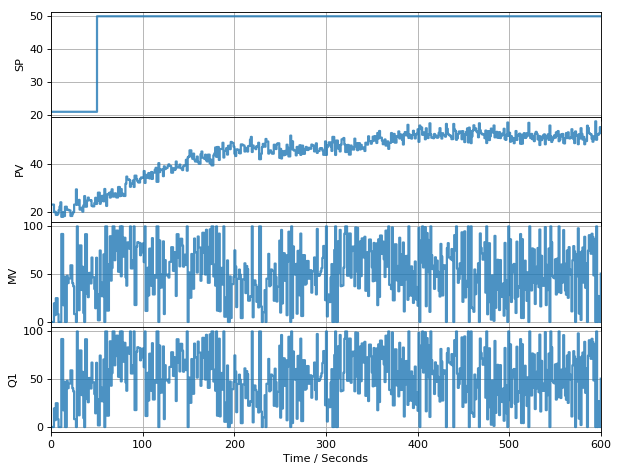

TCLab Model disconnected successfully.


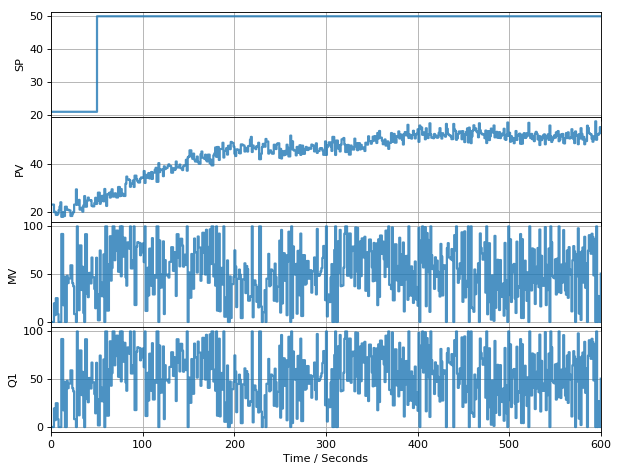

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter
import numpy as np

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 10, beta=0)   # create pid control
controller.send(None)                  # initialize

tfinal = 600

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('PV', lambda: PV), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 1):
        SP = T1 if t < 50 else 50                     # get setpoint
        PV = lab.T1 + 2*np.random.normal()            # get measurement
        MV = controller.send([t, PV, SP, lab.Q1()])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display

## 4.5.2 Modifying the Derivative Term

To avoid problems with high frequency measurement noise and disturbances, consider an implementation of the derivative term of PID control using a first-order model

\begin{align}
\tau_f \frac{dD}{dt} + D & = K_D \frac{de^D}{dt}
\end{align}

where $e^D = \gamma SP - PV$ is the setpoint weighted error. The idea behind this model is that, for slowly varying changes, $D \sim K_d \frac{de_D}{dt}$ which provides the desired derivative control function, and for more rapidly varying changes $\tau_f \frac{dD}{dt} + D \sim K_d \frac{de_D}{dt}$ which dissipates the influence of more rapidly varying changes attributable to measurement noise.

The characteristic time constant $\tau_f$ is chosen as a fraction of the derivative time constant $\tau_D$

\begin{align}
\tau_f & = \frac{\tau_D}{N} = \frac{K_D}{NK_P}
\end{align}

Rearraging for $D$ and integrating this model gives

\begin{align}
D & =  \frac{K_D}{\tau_f} e^D - \frac{1}{\tau_f} \int_0^t D\ dt 
\end{align}

In discrete time we define and use a backwards difference approximation to obtain

\begin{align}
S_k & = \int_0^{t_k} D\ dt \\
& \approx \sum_{k'=1 }^{k} D_{k'} (t_{k'} - t_{k'-1}) = D_k (t_k - t_{k-1}) + S_{k-1}
\end{align}

The backwards difference approximation provides a recursion relationship that is stable for all $t_k \geq t_{k-1}$. We are thereby tracking a pair of implicit recursion relations

\begin{align}
D_k & = \frac{K_D}{\tau_f} e^D_k - \frac{1}{\tau_f} \left[ D_k(t_k - t_{k-1}) + S_{k-1} \right] \\
\\
S_k & = D_k (t_k - t_{k-1}) + S_{k-1}
\end{align}

Making these explicit

\begin{align}
D_k & = \frac{K_D e^D_k - S_{k-1}}{\tau_f + (t_k - t_{k-1})}  \\
\\
S_k & = D_k (t_k - t_{k-1}) + S_{k-1}
\end{align}

Finally, using parameters for the non-interacting model of PID control

\begin{align}
D_k & = \frac{NK_P(K_De^D_k - S_{k-1})}{K_D + NK_P(t_k - t_{k-1})}  \\
\\
S_k & = D_k (t_k - t_{k-1}) + S_{k-1}
\end{align}

This recursive calculation can be initialized with $S_0 = K_De^D_0$.

## 4.5.3 Example Revisited

To show the impact of this change in the implementation of the derivative term, we repeat the experiment above with the revised algorithm and $N = 1$.  (A more typical value of $N$ is 5 or 10, but we've chosen a somewhat more conservative value because of the magnitude of the measurement noise present in this example, and the large value of $K_D$ chosen to demonstrate the issues.

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0, MV_min=0, MV_max=100, beta=1, gamma=0, N=10):

    # initial yield and return
    data = yield MV_bar
    t,  = data[0:3]
    
    P = Kp*(beta*SP - PV)
    MV = MV_bar + P
    MV = 0 if MV < 0 else 100 if MV > 100 else MV
    I = 0
    D = 0
    dI = 0
    
    S = Kd*(gamma*SP - PV)
    t_prev = t
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV, P, I, D, dI
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, PV, SP = data
        else:
            t, PV, SP, TR = data
            d = MV - TR
            #I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        eD = gamma*SP - PV
        D = N*Kp*(Kd*eD - S)/(Kd + N*Kp*(t - t_prev))
        
        # conditional integration
        dI = Ki*(SP - PV)*(t - t_prev)
        if (MV_bar + P + I + D + dI) > MV_max:
            dI = max(0, min(dI, MV_max - MV_bar - P - I - D))
        if (MV_bar + P + I + D + dI) < MV_min:
            dI += min(0, max(dI, MV_min - MV_bar - P - I - D))
        I += dI
        MV = MV_bar + P + I + D 
        
        # Clamp MV to range 0 to 100 for anti-reset windup
        MV = max(MV_min, min(MV_max, MV))
        
        # update stored data for next iteration
        S = D*(t - t_prev) + S
        t_prev = t

The desired setpoint is 50°C which is acheived with a power setting of approximately 50%.  We'll start out at the power setting for a period of 400 seconds, then turn on the controller.

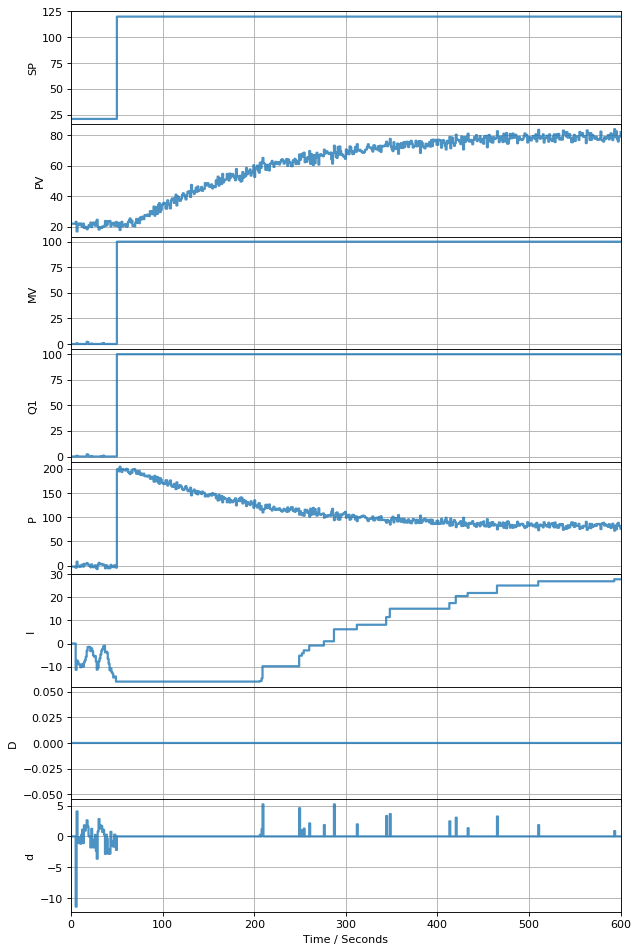

TCLab Model disconnected successfully.


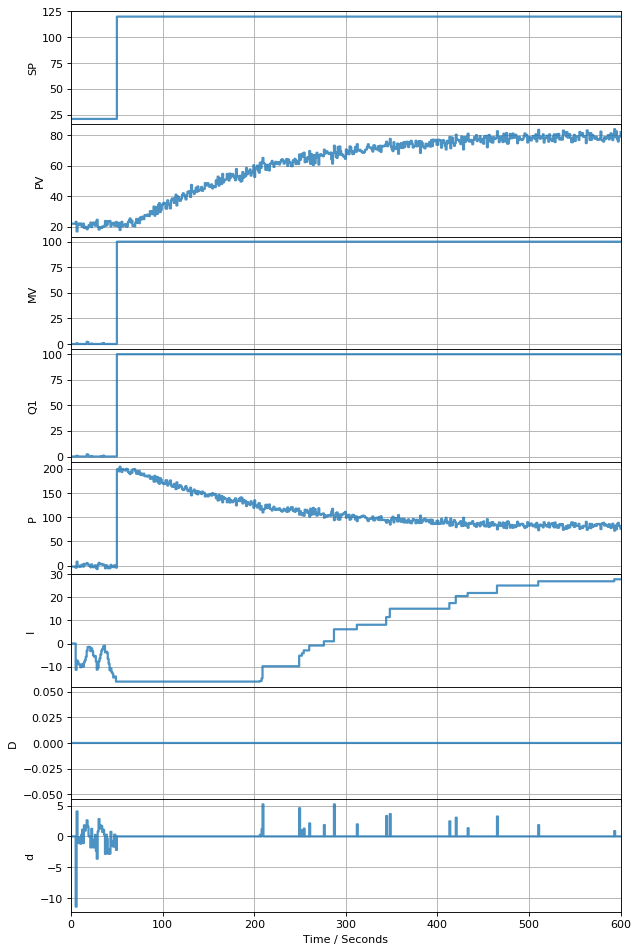

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter
import numpy as np

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 1, 0, beta=1, N=1)   # create pid control
controller.send(None)                  # initialize

tfinal = 600

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('PV', lambda: PV), ('MV', lambda: MV), ('Q1', lab.Q1),
                   ('P', lambda: P), ('I', lambda: I), ('D', lambda: D), ('d', lambda: d)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 1):
        SP = T1 if t < 50 else 120                     # get setpoint
        PV = lab.T1 + 2*np.random.normal()            # get measurement
        MV, P, I, D, d = controller.send([t, PV, SP, lab.Q1()])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display

# 4.6 PID Controller Tuning

We have previously discussed many of the features that should be included in any practical implementation of PID control. The notebook addresses the core issue of how to find appropriate values for the control constants $K_P$, $K_I$, and $K_D$ in the non-interacting model for PID control

\begin{align}
MV & = \overline{MV} + K_P(\beta\ SP - PV) + K_I \int^{t} (SP - PV)\ dt + K_D \frac{d(\gamma\ SP - PV)}{dt}
\end{align}

where we have include setpoint weights $\beta$ and $\gamma$ for the proportional and derivative terms, respectively. In the case where the PID model is given in the standard ISA form

\begin{align}
MV & = \overline{MV} + K_c\left[(\beta\ SP - PV) + \frac{1}{\tau_I}\int^{t} (SP - PV)\ dt + \tau_D \frac{d(\gamma\ SP - PV)}{dt}\right]
\end{align}

the equivalent task is to find values for the control gain $K_c$, the integral time constant $\tau_I$, and derivative time constant $\tau_D$. The equivalence of these models is established by the following relationships among the parameters

\begin{align}
\begin{array}{ccc}
\mbox{ISA} \rightarrow \mbox{Non-interacting} & & \mbox{Non-interacting} \rightarrow \mbox{ISA} \\
K_P = K_c & & K_c = K_P\\
K_I = \frac{K_c}{\tau_I} & & \tau_I = \frac{K_P}{K_I}\\
K_D = K_c\tau_D & & \tau_D = \frac{K_D}{K_P}
\end{array}
\end{align}

### 4.6.1 Empirical Methods

Determining PID control parameters is complicated by the general absence of process models for most applications. Typically the control implementation takes place in three steps:

1. **Idenfication.** A prescribed experiment is performed to create an empirical model for the response of the process to the manipulated input.
2. **Control Design.** Given an empirical model, find PID control parameters that provide setpoint response, disturbance rejection, and robustness to modeling errors.
3. **Validation.** Perform a series of test to validate control performance under normal and extreme conditions.

Identification is normally limited to procedures that can be completed with minimal equipment downtime, and without extensive support from  

Åström, Karl J., and Tore Hägglund. "Advanced PID control." The Instrumentation Systems and Automation Society. 2006.

Åström, Karl J., and Tore Hägglund. "Revisiting the Ziegler–Nichols step response method for PID control." Journal of process control 14, no. 6 (2004): 635-650.

Garpinger, Olaf, Tore Hägglund, and Karl J. Åström. "Performance and robustness trade-offs in PID control." Journal of process control 24(2004): 568-577.

The basic approach to tuning PID controllers is to:

1. Perform a specified experiment to extract key parameters that specify process behavior.
3. From the process parameters, use formula to determine control constants.
4. Test the resulting controller for setpoint tracking and disturbance rejection.

The methods we'll be discussing differ in the type of experiment to be performed, the parameters extracted from experimental results, and the assumptions underlying the choice of control parameters. The methods we'll cover are commonly used in industry, and should be in the toolkit of most chemical engineers.

1. AMIGO
2. Ziegler-Nichols
3. Relay Tuning

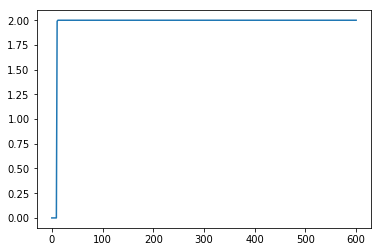

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def fopdt(t, K, tau, theta):
    return K*(1 - np.exp(-(t-theta)/tau))*(t > theta)


t = np.linspace(0,600,400)

y = fopdt(t, 2, .1, 10)

plt.plot(t, y)

## 4.6.1 PID Reference Implementation

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    t_prev = -100
    P = 0
    I = 0
    D = 0
    S = 0
    N = 5
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, SP, PV = data
        else:
            t, SP, PV, TR = data
            I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = N*Kp*(Kd*eD - S)/(Kd + N*Kp*(t - t_prev))
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        I = MV - MV_bar - P - D
        
        # update stored data for next iteration
        S = D*(t - t_prev) + S
        t_prev = t

## 4.6.2 AMIGO Tuning

### 4.6.2.1 KLT Model - First Order with Dead Time

AMIGO tuning assumes a so-called KLT process model with three parameters

\begin{align}
\tau \frac{d y}{dt} + y = K u(t-\theta)
\end{align}

where $y$ is the deviation of the process variable from a nominal steady-state value ($PV - \overline{PV}$), $u$ is a deviation in the manipulated manipulated variable from a nominal value ($MV - \overline{MV}$), and the parameters have the following descriptions.

| | |
| :-: | :-: |
|$K$| static gain |
|$\tau$| first-order time constant  (T, or Time constant)
|$\theta$| time-delay (L, or Lag)

These parameters can be determined from step testing.

### 4.6.2.2 Tuning Rules

The AMIGO tuning rules provide values for the PID parameters $K_c$, $\tau_I$, $\tau_D$ in addition to setpoint weights $\beta$ and $\gamma$.

\begin{align}
K_c & = \frac{1}{K}\left(0.2 + 0.45\frac{\tau}{\theta}\right) \\
\\
\tau_I & = \frac{0.4\theta + 0.8\tau}{\theta + 0.1\tau}\theta \\
\\
\tau_D & = \frac{0.5\theta\tau}{0.3\theta + \tau} \\
\\
\beta & = \begin{cases} 0 & \theta \lt \tau \\ 1 & \theta \gt \tau \end{cases} \\
\\
\gamma & = 0
\end{align}

For proportional-integral (PI) control, the tuning rules are

\begin{align}
K_c & = \frac{1}{K}\left(0.15 + 0.35\frac{\tau}{\theta} - \frac{\tau^2}{(\theta + \tau)^2}\right) \\
\\
\tau_I & = \left(0.35 + \frac{13\tau^2}{\tau^2 + 12\theta\tau + 7\theta^2} \right)\theta \\
\\
\beta & = \begin{cases} 0 & \theta \lt \tau \\ 1 & \theta \gt \tau \end{cases} \\
\\
\gamma & = 0
\end{align}

Based on extensive simulation studies, the AMIGO tuning rules generally provide good performance for systems dynamics that are dominated by time lag $\theta > \tau$. The tuning rules are generally found to be overly conservative for $\theta < \tau$.

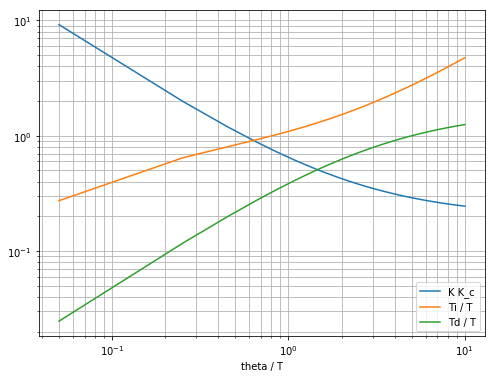

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

r = np.linspace(0.05,10)
kr = 0.2 + 0.45/r
ir = r*(0.4*r + 0.8)/(r + 0.1)
dr = 0.5*r/(0.3*r + 1)
plt.figure(figsize=(8,6))
plt.loglog(r,kr,r,ir,r,dr)
plt.legend(['K K_c','Ti / T','Td / T'])
plt.xlabel('theta / T')
plt.grid(True, which='both')

## 4.6.3 Ziegler Nichols Tuning

## 4.6.4 Relay Tuning

In [ ]:
def relay(SP, a = 5):
    MV = 0
    while True:
        PV = yield MV
        MV_prev = MV
        MV = 100 if PV < SP - a else 0 if PV > SP + a else MV_prev

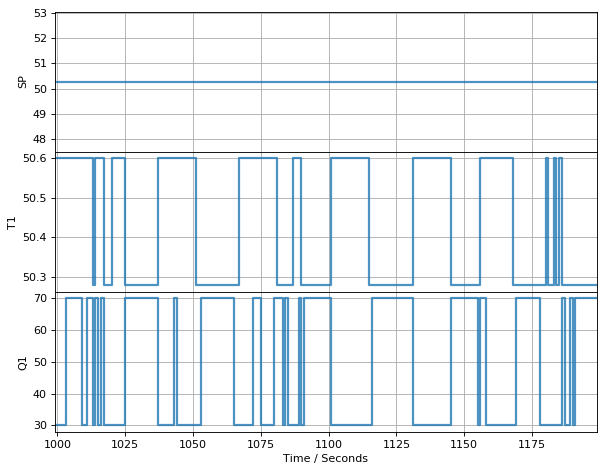

TCLab Model disconnected successfully.


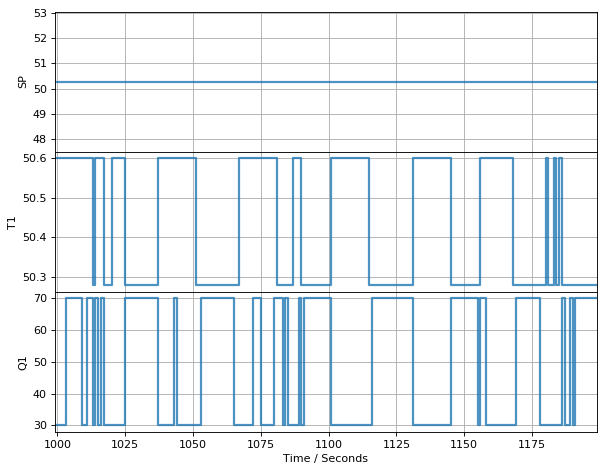

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=20)

tfinal = 1200
MV_bar = 50
hMV = 20

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('Q1', lab.Q1)])
    p = Plotter(h, 200)
    T1 = lab.T1
    for t in clock(tfinal, 1):
        if t < 600:
            SP = lab.T1
            MV = MV_bar
        else:
            MV = (MV_bar - hMV) if (lab.T1 > SP) else (MV_bar + hMV)
        lab.Q1(MV)
        p.update(t)                                   # update information display

In [ ]:
Pu = 140
h = 20
a = 1.5

Ku = 4*h/a/3.14


In [ ]:
Ku

16.985138004246284

In [ ]:
Kp = Ku/2
Ti = Pu/2
Td = Pu/8

Ki = Kp/Ti
Kd = Kp*Td
print(Kp, Ki, Kd)

8.492569002123142 0.12132241431604489 148.619957537155


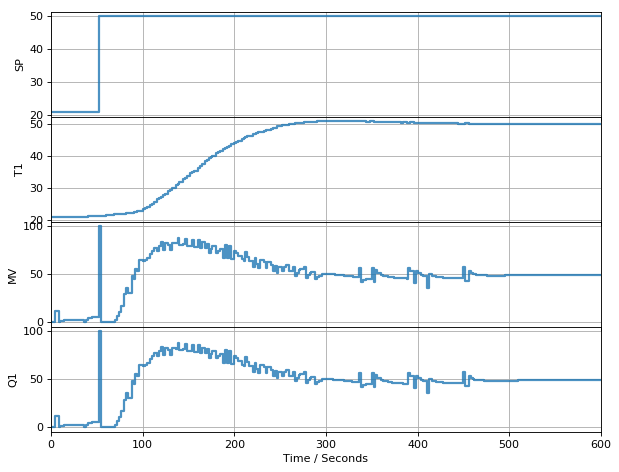

TCLab Model disconnected successfully.


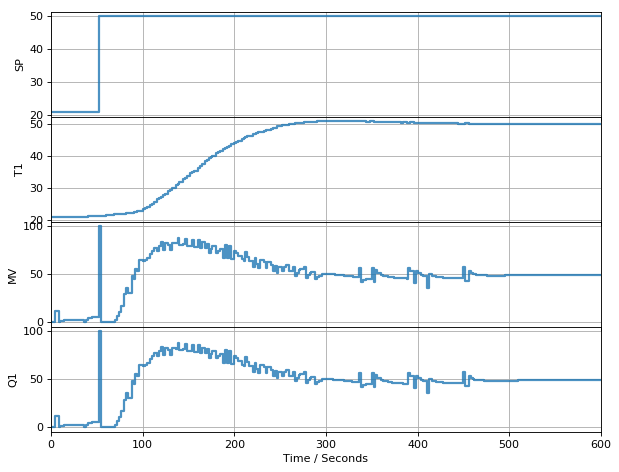

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(Kp, Ki, Kd, beta=1, gamma=1)   # create pid control
controller.send(None)                 # initialize

tfinal = 600

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50                     # get setpoint
        PV = lab.T1                                   # get measurement
        MV = controller.send([t, SP, PV])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display

## 4.6.5 Exercise: Compare the performance of these tuning rules.

To be written.

# 4.10 PID Control - Laboratory

## 4.10.1 PID Control

The following Python code creates a PID generator that can be use for feedback control.  This the same generator we developed in class on Thursday, with an additional filter used for a more robust implementation of derivative action.  In today's laboratory you will use this code to test several aspects of feedback control of the TCLab heater.

In [ ]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    t_prev = -100
    P = 0
    I = 0
    D = 0
    S = 0
    N = 10
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, SP, PV = data
        else:
            t, SP, PV, TR = data
            I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = N*Kp*(Kd*eD - S)/(Kd + N*Kp*(t - t_prev))
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        I = MV - MV_bar - P - D
        
        # update stored data for next iteration
        S = D*(t - t_prev) + S
        t_prev = t

## 4.10.2 Exercise 1.  Is the transfer from manual to automatic bumpless?

The cell below is a starter code to implement feedback control. The code establishes a setpoint of 40°C, and for the first 30 seconds runs under manual control. The control then transfers to automatic. Do you observe bumpless transfer?  Explain what you see.

In [ ]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=True)

controller = PID(Kp=2, Ki=0.1, Kd=2, beta=0)   # create pid control
controller.send(None)                          # initialize

tfinal = 600
SP = 40

with TCLab() as lab:
    sources = [('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)]
    h = Historian(sources)
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1                            # get measurement
        MV = controller.send([t, SP, PV, lab.U1])  # for bumpless transfer
        if t < 100:                            # choice between manual and auto control
            MV = 50
        lab.U1 = MV                            # apply 
        p.update(t)                            # update information display

In [ ]:
from tclab import diagnose

diagnose()

Looking for Arduino on  ...
NHduino found on port /dev/cu.wchusbserial1410

Testing TCLab object in debug mode
----------------------------------
TCLab version 0.4.6dev
Sent: "Q1 0"
Return: ""
Sent: "Q1 0"
Return: "0"
Could not connect at high speed, but succeeded at low speed.
This may be due to an old TCLab firmware.
New Arduino TCLab firmware available at:
 https://github.com/jckantor/TCLab-sketch
Sent: "VER"
Return: "TCLab Firmware Version 1.2.1"
NHduino connected on port /dev/cu.wchusbserial1410 at 9600 baud.
TCLab Firmware Version 1.2.1.
Sent: "Q2 0"
Return: "0"
Reading temperature
Sent: "T1"
Return: "27.02"
27.02
Sent: "Q1 0"
Return: "0"
Sent: "Q2 0"
Return: "0"
Sent: "X"
Return: "X"
TCLab disconnected successfully.

Testing TCLab functions
-----------------------
TCLab version 0.4.6dev
Could not connect at high speed, but succeeded at low speed.
This may be due to an old TCLab firmware.
New Arduino TCLab firmware available at:
 https://github.com/jckantor/TCLab-sketch
NHduino c

## 4.10.3 Exercise 2

Create a new experiment in the cell below.  The new experiment should do the following:

* Add a second PID controller for the second heater.  The control constants should be Kp=4, Ki=0.2, Kd=2, beta=0.
* Should start up under automatic control with setpoints of 40 deg C for both heaters.  
* At t = 100, the setpoint for heater 1 should be raised to 50 deg C
* You will need to modify the 'sources' line to include the additional data.  Please see an instructor if you need help with this.

Run the experiment for at least 800 seconds.  How would describe the behavior at the point when the setpoint is changed?

In [ ]:
from tclab import diagnose
diagnose()


Looking for Arduino on  ...
NHduino found on port /dev/cu.wchusbserial1410

Testing TCLab object in debug mode
----------------------------------
TCLab version 0.4.6dev
Sent: "Q1 0"
Return: ""
Sent: "Q1 0"
Return: "0"
Could not connect at high speed, but succeeded at low speed.
This may be due to an old TCLab firmware.
New Arduino TCLab firmware available at:
 https://github.com/jckantor/TCLab-sketch
Sent: "VER"
Return: "TCLab Firmware Version 1.2.1"
NHduino connected on port /dev/cu.wchusbserial1410 at 9600 baud.
TCLab Firmware Version 1.2.1.
Sent: "Q2 0"
Return: "0"
Reading temperature
Sent: "T1"
Return: "21.54"
21.54
Sent: "Q1 0"
Return: "0"
Sent: "Q2 0"
Return: "0"
Sent: "X"
Return: "X"
TCLab disconnected successfully.

Testing TCLab functions
-----------------------
TCLab version 0.4.6dev
Could not connect at high speed, but succeeded at low speed.
This may be due to an old TCLab firmware.
New Arduino TCLab firmware available at:
 https://github.com/jckantor/TCLab-sketch
NHduino c

# 4.11 Implementing PID Control in Nonlinear Simulations

A task common to many control projects is to simulate the PID control of a nonlinear process. This notebook demonstrates the simulation of PID for an exothermic stirred tank reactor where the objective is to control the reactor temperature through manipulation of cooling water through the reactor cooling jacket.

![Exothermic Reactor](figures/408px-Agitated_vessel.png)

(Diagram By [Daniele Pugliesi](http://commons.wikimedia.org/wiki/User:Daniele_Pugliesi) - Own work, [CC BY-SA 3.0](http://creativecommons.org/licenses/by-sa/3.0), [Link](https://commons.wikimedia.org/w/index.php?curid=6915706))

## 4.11.1 Model

The model consists of nonlinear mole and energy balances on the contents of the well-mixed reactor.

\begin{align*}
V\frac{dc}{dt} & = q(c_f - c )-Vk(T)c \\
\rho C_p V\frac{dT}{dt} & = wC_p(T_f - T) + (-\Delta H_R)Vk(T)c + UA(T_c-T)
\end{align*}

where $c$ is the reactant concentration, $T$ is the reactor temperature, and $T_c$ is the cooling jacket temperature. The model is adapted from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD), parameters defined and given in the table below.

The temperature in the cooling jacket is manipulated by the cooling jacket flow, $q_c$, and governed by the energy balance

\begin{align*}
\rho C_p V_c\frac{dT_c}{dt} & = \rho C_p q_c(T_{cf}-T_c) + UA(T - T_c)
\end{align*}

Normalizing the equations to isolate the time rates of change of $c$, $T$, and $T_c$ give

\begin{align*}
\frac{dc}{dt} & = \frac{q}{V}(c_f - c)- k(T)c\\
\frac{dT}{dt} & = \frac{q}{V}(T_i - T) + \frac{-\Delta H_R}{\rho C_p}k(T)c + \frac{UA}{\rho C_pV}(T_c - T)\\
\frac{dT_c}{dt} & = \frac{q_c}{V_c}(T_{cf}-T_c) + \frac{UA}{\rho C_pV_c}(T - T_c)
\end{align*}

These are the equations that will be integrated below.

| Quantity | Symbol | Value | Units | Comments |
| :------- | :----: | :---: | :---- | |
| Activation Energy | $E_a$ | 72,750 | J/gmol | |
| Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
| Gas Constant | $R$ | 8.314 | J/gmol/K | |
| Reactor Volume | $V$ | 100 | liters | |
| Density | $\rho$ | 1000 | g/liter | |
| Heat Capacity | $C_p$ | 0.239 | J/g/K | |
| Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
| Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
| Feed flowrate | $q$ | 100 | liters/min | |
| Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
| Feed temperature | $T_f$ | 350 | K | |
| Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
| Initial temperature | $T_0$ | 350 | K | |
| Coolant feed temperature | $T_{cf}$ | 300 | K |  |
| Nominal coolant flowrate | $q_c$ | 50 | L/min | primary manipulated variable |
| Cooling jacket volume | $V_c$ | 20 | liters | |

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import seaborn as sns
sns.set_context('talk')

Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q = 100.0       # Flowrate [L/min]
Cf = 1.0        # Inlet feed concentration [mol/L]
Tf  = 300.0     # Inlet feed temperature [K]
C0 = 0.5        # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tcf = 300.0     # Coolant feed temperature [K]
qc = 50.0       # Nominal coolant flowrate [L/min]
Vc = 20.0       # Cooling jacket volume

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

def deriv(X,t):
    C,T,Tc = X
    dC = (q/V)*(Cf - C) - k(T)*C
    dT = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*C + (UA/V/rho/Cp)*(Tc - T)
    dTc = (qc/Vc)*(Tcf - Tc) + (UA/Vc/rho/Cp)*(T - Tc)
    return [dC,dT,dTc]

## 4.11.2 Simulation 1. Same Initial Condition, different values of $q_c$

The given reaction is highly exothermic. If operated without cooling, the reactor will reach an operating temperature of 500K which leads to significant pressurization, a potentially hazardous condition, and possible product degradation. 

The purpose of this first simulation is to determine the cooling water flowrate necessary to maintain the reactor temperature at an acceptable value. This simulation shows the effect of the cooling water flowrate, $q_c$, on the steady state concentration and temperature of the reactor.  We use the scipy.integrate function `odeint` to create a solution of the differential equations for entire time period.

In [ ]:
# visualization
def plotReactor(t,X):
    plt.subplot(1,2,1)
    plt.plot(t,X[:,0])
    plt.xlabel('Time [min]')
    plt.ylabel('gmol/liter')
    plt.title('Reactor Concentration')
    plt.ylim(0,1)

    plt.subplot(1,2,2)
    plt.plot(t,X[:,1])
    plt.xlabel('Time [min]')
    plt.ylabel('Kelvin');
    plt.title('Reactor Temperature')
    plt.ylim(300,520)

Once the visualization code has been established, the actual simulation is straightforward.

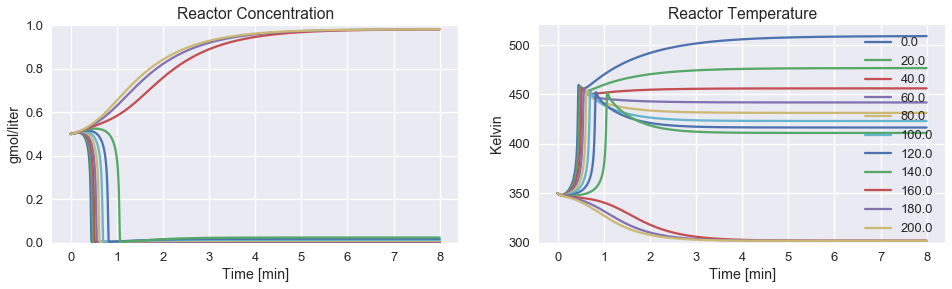

In [ ]:
IC = [C0,T0,Tcf]                        # initial condition
t = np.linspace(0,8.0,2000)             # simulation time grid

qList = np.linspace(0,200,11)

plt.figure(figsize=(16,4))              # setup figure 
for qc in qList:                        # for each flowrate q_c
    X = odeint(deriv,IC,t)              # perform simulation
    plotReactor(t,X)                    # plot the results
    
plt.legend(qList)

The results clearly show a strongly nonlinear behavior for cooling water flowrates in the range from 140 to 160 liters per minute. Here we expand on that range to better understand what is going on.

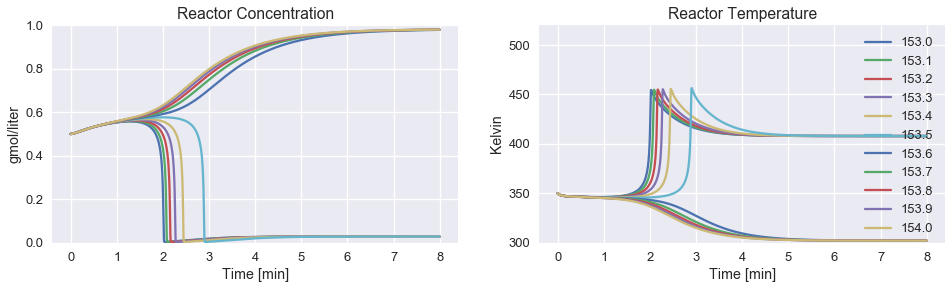

In [ ]:
IC = [C0,T0,Tcf]                        # initial condition
t = np.linspace(0,8.0,2000)             # simulation time grid

qList = np.linspace(153,154,11)

plt.figure(figsize=(16,4))              # setup figure 
for qc in qList:                        # for each flowrate q_c
    X = odeint(deriv,IC,t)              # perform simulation
    plotReactor(t,X)                    # plot the results
    
plt.legend(qList)

There's a clear bifurcation when operated without feedback control. At cooling flowrates less than 153.7 liters/minute, the reactor goes to a high conversion steady state with greater than 95% conversion and a reactor temperature higher than about 410K. Coolant flowrates less than 153.8 liters/minute result in uneconomic operation at low conversion.

For the remainder of this notebook, our objective will be to achieve stable operation of the reactor at a high conversion steady state but with an operating temperature below 400 K, an operating condition that does not appear to be possible without feedback control.

## 4.11.3 Simulation 2.  Fixed Time Grid

Introducing feedback control requires a change in the simulation strategy. 

The new approach will be to break the simulation interval up into small time steps of length $dt$.  At each breakpoint a PID control calculation will be performed, the coolant flow updated, then `odeint` will be used to simulate the reactor up to the next breakpoint.

The following cell demontrates the simulation strategy assuming a constant coolant flowrate. Note the use of Python lists to log simulation values for later plotting.

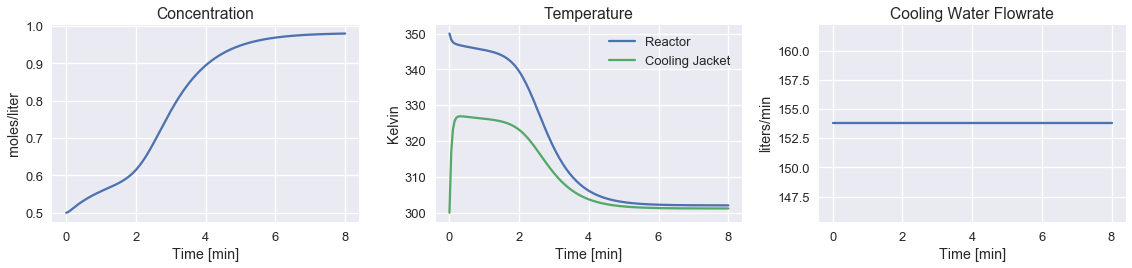

In [ ]:
# set initial conditions and cooling flow
IC = [C0,T0,Tcf]

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 8.0

# create python list to log results
log = []

# start simulation
c,T,Tc = IC
qc = 153.8
for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
    log.append([t,c,T,Tc,qc])                      # log data for later plotting
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]   # start at t, find state at t + dt

def qplot(log):
    log = np.asarray(log).T
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.plot(log[0],log[1])
    plt.title('Concentration')
    plt.ylabel('moles/liter')
    plt.xlabel('Time [min]')

    plt.subplot(1,3,2)
    plt.plot(log[0],log[2],log[0],log[3])
    if 'Tsp' in globals():
        plt.plot(plt.xlim(),[Tsp,Tsp],'r:')
    plt.title('Temperature')
    plt.ylabel('Kelvin')
    plt.xlabel('Time [min]')
    plt.legend(['Reactor','Cooling Jacket'])

    plt.subplot(1,3,3)
    plt.plot(log[0],log[4])
    plt.title('Cooling Water Flowrate')
    plt.ylabel('liters/min')
    plt.xlabel('Time [min]')
    plt.tight_layout()

SS = log[-1]
qplot(log)


## 4.11.4 Simulation 3.  Proportional-Integral-Derivative Control

Proportional-Integral-Derivative (PID) control is the workhorse of the process control industry. In standard form, the PID algorithm would be written

$$q_c(t) = \bar{q}_c - K_c\left[(T_{sp}-T) + \frac{1}{\tau_I}\int_0^t (T_{sp}-T)dt' + \tau_D\frac{d(T_{sp}-T)}{dt} \right]$$

For the control reactor temperature, note the controller is 'direct-acting' such that a positive excursion of the reactor temperature $T$ above the setpoint $T_{sp}$ is compensated by an increase in coolant flow, and vice-versa. Thus a negative sign appears before the term $K_c$ contrary to the usual textbook convention for negative feedback control.

The practical implementation of PID control is generally facilitated by a number of modifications.

### 4.11.4.1 Independent Parameters

A common practice is to introduce an independent parameterization for each fo the P, I, and D terms.  Rewriting, the control equation becomes

$$q_c(t) = \bar{q}_c - \left[k_P(T_{sp}-T) + k_I\int_0^t (T_{sp}-T)dt' + k_D\frac{d(T_{sp}-T)}{dt} \right]$$

where

\begin{align*}
k_P & = K_c \\
k_I & = \frac{K_c}{\tau_I} \\
k_D & = K_c\tau_D
\end{align*}

### 4.11.4.2 Setpoint Weighting

Step changes in setpoint $T_{sp}$ can produce undesired 'kicks' and 'bumps' if PID control is implemented directly using in standard form. It is common practice to introduce setpoint weighting factors for the proportional and derivative terms. This can be written as 

$$q_c(t) = \bar{q}_c - \left[k_Pe_P(t) + k_I\int_0^t e_I(t')dt' + k_D\frac{e_D(t)}{dt} \right]$$

where

\begin{align*}
e_P(t) & = \beta T_{sp}(t) - T(t) \\
e_I(t) & = T_{sp}(t) - T(t) \\
e_D(t) & = \gamma T_{sp}(t) - T(t)
\end{align*}

Common practice is to set $\gamma = 0$ which eliminates derivative action based on change in the setpoint. This feature is sometimes called 'derivative on output'. This almost always a good idea in process control since it avoids the 'derivative kick' associated with a change in setpoint.

In practice, the term $\beta$ is generally tuned to meet the specific application requirements. In this case, where setpoint tracking is not a high priority, setting $\beta = 0$ is a reasonable starting point.

### 4.11.4.3 Discrete Time Implementation

The simulation strategy adopted here requires a discrete time implementation of PID control. For a sampling time $dt$, the PID algorithm becomes

$$q_c(t_k) = \bar{q}_c - \left[k_Pe_P(t_k) + k_Idt\sum_0^{t_k} e_I(t_{k'}) + k_D\frac{e_D(t_k)-e_D(t_{k-1})}{dt} \right]$$

Implementation is further streamlined by computing changes is $q_c(t_k)$

$$\Delta q_c(t_k) = q_c(t_k) - q_c(t_{k-1})$$

Computing the differences

$$\Delta q_c(t_k) = -\left[k_P(e_P(t_k)-e_P(t_{k-1})) + k_I\ dt\ e_I(t_k) + k_D\frac{e_D(t_k) - 2e_D(t_{k-1}) + e_D(t_{k-2})}{dt}\right]$$

### 4.11.4.4 Bounded Control

A final consideration is that the coolant flows have lower and upper bounds of practical operation. 

$$q_c = \max(q_{c,min},\max(q_{c,max},q_c)) $$

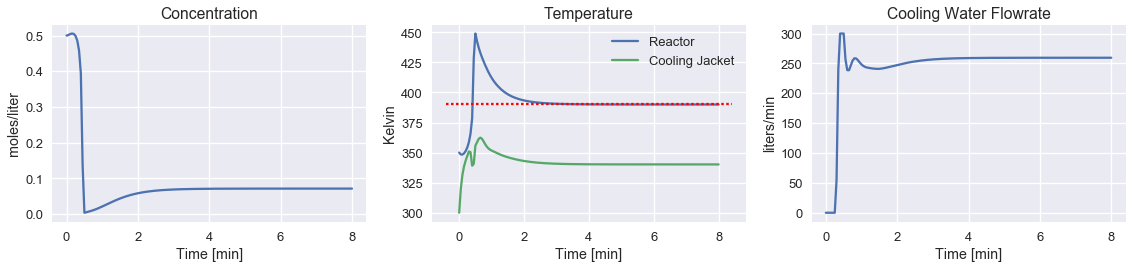

In [ ]:
# setpoint
Tsp = 390

# set initial conditions and cooling flow
IC = [C0,T0,Tcf]

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 8.0

# control saturation
qc_min = 0                            # minimum possible coolant flowrate
qc_max = 300                          # maximum possible coolant flowrate
def sat(qc):                          # function to return feasible value of qc
    return max(qc_min,min(qc_max,qc))

# control parameters
kp = 40
ki = 80
kd = 0
beta = 0
gamma = 0

# create python list to log results
log = []

# start simulation
c,T,Tc = IC
qc = 150

eP_ = beta*Tsp - T
eD_ = gamma*Tsp - T
eD__ = eD_

for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
    # PID control calculations
    eP = beta*Tsp - T
    eI = Tsp - T
    eD = gamma*Tsp - T
    qc -= kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt
    qc = sat(qc)
    
    # log data and update state
    log.append([t,c,T,Tc,qc])
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt
    
    # save data for PID calculations
    eD__,eD_,eP_ = eD_,eD,eP

qplot(log)

## 4.11.5 Simulation 4. Interactive Controller Tuning

In this example, PID control is used to stabilize an otherwise unstable steady state, thereby allowing the reactor to operate at temperature and conversion that would not be possible without control. The acheivable operating conditions are limited by the controller tuning and the limits on the available control action.

The following simulation provides for the interactive adjustment of reactor setpoint temperature and the proportional, integral, and derivative control gains. Adjust these in order to answer the following questions:

1. What is the minimum achieveable temperature setpoint for the reactor with conversion greater than 80%?  What limits the ability to reduce the temperature setpoint even further?

2. Adjust the temperature setpoint to 420K.  Adjust the controller gains for satisfactory closed-loop performance.  Repeat the exercise for a setpoint of 390K. How is the behavior different?  What happens when when the proportional gain is set too small?  Explain what you see.

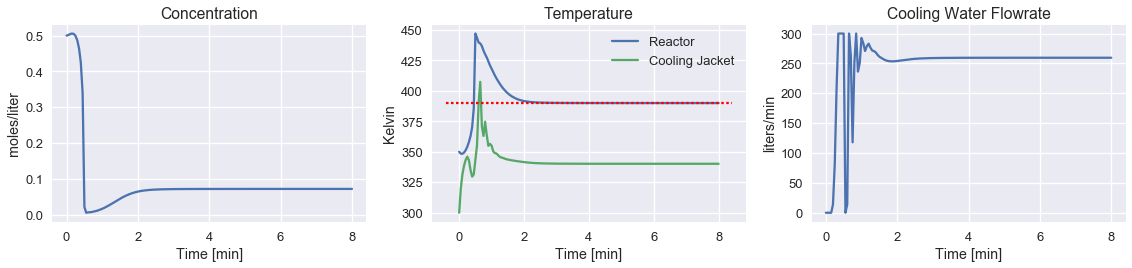

In [ ]:
from ipywidgets import interact

IC = [C0,T0,Tcf]

def sim(Tsetpoint,kp,ki,kd):
    global Tsp, qc
    Tsp = Tsetpoint
    
    # control parameters
    beta = 0
    gamma = 0

    # create python list to log results
    log = []

    # start simulation
    c,T,Tc = IC
    qc = 150

    eP_ = beta*Tsp - T
    eD_ = gamma*Tsp - T
    eD__ = eD_

    for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
        # PID control calculations
        eP = beta*Tsp - T
        eI = Tsp - T
        eD = gamma*Tsp - T
        qc -= kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt
        qc = sat(qc)

        # log data and update state
        log.append([t,c,T,Tc,qc])
        c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt
    
        # save data for PID calculations
        eD__ = eD_
        eD_ = eD
        eP_ = eP

    qplot(log)
    
interact(sim,Tsetpoint = (360,420),kp = (0,80), ki=(0,160), kd=(0,10));

## 4.11.6 Simulation 5. Using the PIDsim Controller Class

From this point on, this notebook describes the development of a PID control class that could be used in more complex simulations. Regard everything after this point as 'try at your own risk'!

Examples of PID Codes in Python:

* [DISCRETE PID CONTROLLER (PYTHON RECIPE)](http://code.activestate.com/recipes/577231-discrete-pid-controller/)
* [ivPID](https://github.com/ivmech/ivPID)
* [python-pid_controller](https://gist.github.com/chaosmail/8372717)
* [PID Controller](https://github.com/chrisspen/pid_controller)
* [pypid 0.4](https://pypi.python.org/pypi/pypid/)
* [PIDController](http://cgkit.sourceforge.net/doc2/pidcontroller.html)
* [PID.py](http://examples.oreilly.com/9780596809577/CH09/PID.py)
* [APMonitor.com](http://apmonitor.com/do/index.php/Main/NonlinearControl)

Below we demonstrate the use of `PIDsim`, a python module that can be used to implement multiple PID controllers in a single simulation. 

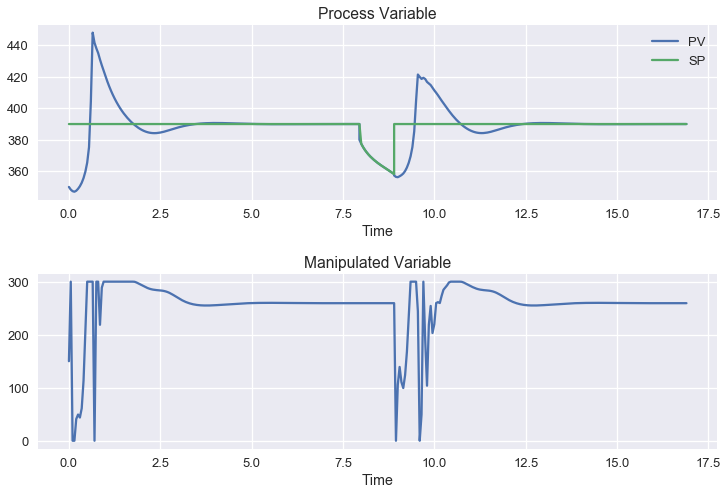

In [ ]:
from PIDsim import PID

# reactor temperature setpoint
Tsp = 390

# set initial conditions and cooling flow
IC = [C0,T0,Tcf]

# do simulation at fixed time steps dt
tstart = 0
tstop = 8
tstep = 0.05

# configure controller. Creates a PID object.
reactorPID = PID(Kp=8,Ki=30,Kd=5,MVrange=(0,300),DirectAction=True)

c,T,Tc = IC                                          # reactor initial conditions
qc = 150                                             # initial condition of the MV
for t in np.arange(tstart,tstop,tstep):              # simulate from tstart to tstop
    qc = reactorPID.update(t,Tsp,T,qc)               # update manipulated variable
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt

reactorPID.manual()                                  # switch to manual model                    
T -= 10                                              # change process variable by -10 deg
for t in np.arange(t,t+1,tstep):                     # simulate for 1 minute
    qc = reactorPID.update(t,Tsp,T,qc)               # continue to update, SP tracks PV
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt

reactorPID.auto()                                    # switch back to auto mode
for t in np.arange(t,t+tstop,tstep):                 # integrate another tstop minutes
    qc = reactorPID.update(t,Tsp,T,qc)               # update MV
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt
    
# plot controller log
reactorPID.plot()                                    # plot controller log

### 4.11.6.1 Contents of PIDsim.py

In [ ]:
# %load PIDsim.py
import matplotlib.pyplot as plt
import numpy as np

class PID:
    """ An implementation of a PID control class for use in process control simulations.
    """
    def __init__(self, name=None, SP=None, Kp=0.2, Ki=0, Kd=0, beta=1, gamma=0, MVrange=(0,100), DirectAction=False):
        self.name = name
        self.SP = SP
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.beta = beta
        self.gamma = gamma
        self.MVrange = MVrange
        self.DirectAction = DirectAction
        self._mode = 'inAuto'
        self._log = []
        self._errorP0 = 0
        self._errorD0 = 0
        self._errorD1 = 0
        self._lastT = 0
        self._currT = 0
        
    def auto(self):
        """Change to automatic control mode. In automatic control mode the .update()
        method computes new values for the manipulated variable using a velocity algorithm.
        """
        self._mode = 'inAuto'
        
    def manual(self):
        """Change to manual control mode. In manual mode the setpoint tracks the process 
        variable to provide bumpless transfer on return to automatic model.
        """
        self._mode = 'inManual'
        
    def _logger(self,t,SP,PV,MV):
        """The PID simulator logs values of time (t), setpoint (SP), process variable (PV),
        and manipulated variable (MV) that can be plotted with the .plot() method.
        """
        self._log.append([t,SP,PV,MV])
        
    def plot(self):
        """Create historical plot of SP,PV, and MV using the controller's internal log file.
        """
        dlog = np.asarray(self._log).T
        t,SP,PV,MV = dlog
        plt.subplot(2,1,1)
        plt.plot(t,PV,t,SP)
        plt.title('Process Variable')
        plt.xlabel('Time')
        plt.legend(['PV','SP'])
        plt.subplot(2,1,2)
        plt.plot(t,MV)
        plt.title('Manipulated Variable')
        plt.xlabel('Time')
        plt.tight_layout()
    
    @property
    def beta(self):
        """beta is the setpoint weighting for proportional control where the proportional error
        is given by error_proportional = beta*SP - PV. The default value is one.
        """
        return self._beta
        
    @beta.setter
    def beta(self,beta):
        self._beta = max(0.0,min(1.0,beta))
        
    @property
    def DirectAction(self):
        """DirectAction is a logical variable setting the direction of the control. A True
        value means the controller output MV should increase for PV > SP. If False the controller
        is reverse acting, and ouput MV will increase for SP > PV. IFf the steady state
        process gain is positive then a control will be reverse acting. 
        
        The default value is False.
        """
        return self._DirectAction
    
    @DirectAction.setter
    def DirectAction(self,DirectAction):
        if DirectAction:
            self._DirectAction = True
            self._action = +1.0
        else:
            self._DirectAction = False
            self._action = -1.0
    
    @property
    def gamma(self):
        """gamma is the setpoint weighting for derivative control where the derivative error
        is given by gamma*SP - PV.  The default value is zero. 
        """
        return self._gamma
    
    @gamma.setter
    def gamma(self,gamma):
        self._gamma = max(0.0,min(1.0,gamma))
    
    @property
    def Kp(self):
        """Kp is the proportional control gain.
        """
        return self._Kp
    
    @Kp.setter
    def Kp(self,Kp):
        self._Kp = Kp
    
    @property
    def Ki(self):
        """Ki is the integral control gain.
        """
        return self._Ki
        
    @Ki.setter
    def Ki(self,Ki):
        self._Ki = Ki
    
    @property
    def Kd(self):
        """Kd is the derivative control gain.
        """
        return self._Kd
    
    @Kd.setter
    def Kd(self,Kd):
        self._Kd = Kd
        
    @property
    def MV(self):
        """MV is the manipulated (or PID outpout) variable. It is automatically
        restricted to the limits given in MVrange.
        """
        return self._MV
    
    @MV.setter
    def MV(self,MV):
        self._MV = max(self._MVmin,min(self._MVmax,MV))
        
    @property
    def MVrange(self):
        """range is a tuple specifying the minimum and maximum controller output.
        Default value is (0,100).
        """
        return (self._MVmin,self._MVmax)
    
    @MVrange.setter
    def MVrange(self,MVrange):
        self._MVmin = MVrange[0]
        self._MVmax = MVrange[1]

    @property
    def SP(self):
        """SP is the setpoint for the measured process variable.
        """
        return self._SP
    
    @SP.setter
    def SP(self,SP):
        self._SP = SP
        
    @property
    def PV(self):
        """PV is the measured process (or control) variable.
        """
        return self._PV
    
    @PV.setter
    def PV(self,PV):
        self._PV = PV

    def update(self,t,SP,PV,MV):
        self.SP = SP
        self.PV = PV
        self.MV = MV 
        if t > self._lastT:
            dt = t - self._lastT
            self._lastT = t
            if self._mode=='inManual':
                self.SP = PV
            self._errorP1 = self._errorP0
            self._errorP0 = self.beta*self.SP - self.PV
            self._errorI0 = self.SP - self.PV            
            self._errorD2 = self._errorD1
            self._errorD1 = self._errorD0
            self._errorD0 = self.gamma*self.SP - self.PV
            if self._mode=='inAuto':
                self._deltaMV = self.Kp*(self._errorP0 - self._errorP1) \
                    + self.Ki*dt*self._errorI0 \
                    + self.Kd*(self._errorD0 - 2*self._errorD1 + self._errorD2)/dt
                self.MV -= self._action*self._deltaMV
        self._logger(t,self.SP,self.PV,self.MV)
        return self.MV 


# 4.12 Interactive PID Control Tuning with  Ziegler-Nichols

## 4.12.1 Summary

This notebook demonstrates methods for tuning PID controllers using Ziegler-Nichols and other tuning rules.

## 4.12.2 Notebook Initialization

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as control

## 4.12.3 Block Diagram of the Closed-Loop Control System

The task is to design and tune a PID controller for the closed-loop block shown in the figure below with signal descriptions given in the following table:

| Signal | Description |
| :----: | :---------- |
| $u$    | command to manipulated variable |
| $d$    | disturbance variable input |
| $y$    | controlled varable process output |
| $r$    | controlled variable setpoint |

Transfer functions corresponding to the valve dynamics $G_v(s)$, the process transfer function $G_p(s)$, the disturbance transfer function $G_d(s)$ and measurement transfer function $G_m(s)$ are specified in subsequent cells.

![figures/controlloop.png](figures/controlloop.png)

### 4.12.3.1 Process Transfer Functions

Valve dynamics:
$$G_v(s) = \frac{1}{2s + 1}$$

Process dynamics:
$$G_p(s) = \frac{1}{5s + 1}$$

Disturbance dynamics:
$$G_d(s) = \frac{1}{5s + 1}$$


In [ ]:
Gv = control.tf([1],[2,1])
Gp = control.tf([1],[5,1])
Gd = control.tf([1],[5,1])
print(Gv,Gp,Gd)


   1
-------
2 s + 1
 
   1
-------
5 s + 1
 
   1
-------
5 s + 1



### 4.12.3.2 Measurement Transfer Function

The measurement consists of a pure time delay of 1 minute modeled by the transfer function 

$$G_m(s) = e^{-\tau_d s}$$

where $\tau_d = 1$. The python control library does not currently incorporate time delays modeled by exponentials, therefore an approximation is necessary. The first order Pade approximation is given by

$$e^{-\tau_d s} \approx \frac{-\frac{\tau_d}{2}s + 1}{\frac{\tau_d}{2}s + 1}$$

This is implemented in the python control library by the function `pade(tdelay,norder)` where `tdelay` is the length of the time delay, and `norder` is the order of approximation.

In [ ]:
tdelay = 1
norder = 1
num,den = control.pade(tdelay,norder)
Gm = control.tf(num,den)
print(Gm)


-s + 2
------
s + 2



### 4.12.3.3 Proportional-Integral (PI) Control

The classical form for PI control is given by 

$$G_c(s) = K_c\left(1 + \frac{1}{\tau_I s}\right)$$

where $K_c$ is the proportional control gain, and $\tau_I$ in the integrator time constant. Note the making $K_c$ very small is equivalent to turning off the controller, while making $\tau_I$ very large is equivalent to turning off just the integrating portion of the controller.

In the transfer function format

$$G_c(s) = K_c\frac{\tau_I s + 1}{\tau_I s + 0}$$

In [ ]:
Kc = 1
tauI = 100

Gc = Kc*control.tf([tauI,1],[tauI,0])
print(Gc)


100 s + 1
---------
  100 s



## 4.12.4 Closed-Loop Transfer Functions

### 4.12.4.1 Definitions

The task we're given is to choose the parameters for a P, PI, or PID controller that result in the good system response. How do we determine if the system response is good or not?

The key to this analysis is to consider a set of four responses

| Response | Transfer function | Description |
| :------: | :---------------: | :---------- |
| $r \rightarrow y$ | $H_{yr}$ | output response to a setpoint change (ideally 1) |
| $d \rightarrow y$ | $H_{yd}$ | output response to a disturbance (ideally 0) |
| $r \rightarrow u$ | $H_{ur}$ | manipulated variable response to a setpoint change |
| $d \rightarrow u$ | $H_{ud}$ | manipulated variable resposne to a disturbance |

Only by examining all four of these can you reach a determination of whether the controller does a good job with respect to both setpoint tracking and disturbance rejection, and that it acheives good output control without excessive or unacceptable changes in the manipulated variable.

The notation use $H$ to designate a closed-loop transfer function and subscripts to indicate the particular pairing of system inputs and outputs. The subscripts correspond to the row and column indices in a matrix equation

$$\left[\begin{array}{c} y \\ u \end{array}\right] =
\left[\begin{array}{cc} H_{yr} & H_{yd} \\ H_{ur} & H_{ud} \end{array}\right]
\left[\begin{array}{c} r \\ d \end{array}\right]$$

For the closed-loop block diagram shown above, the closed-loop transfer functions are given by

$$H_{yr} = \frac{G_p G_v G_c}{1 + G_p G_v G_c G_m}$$

$$H_{yd} = \frac{G_d}{1 + G_p G_v G_c G_m}$$

$$H_{ur} = \frac{G_c}{1 + G_c G_m G_p G_v}$$

$$H_{ud} = -\frac{G_c G_m G_d}{1 + G_c G_m G_p G_v}$$

In [ ]:
Hyr = Gp*Gv*Gc/(1+Gp*Gv*Gc*Gm)
Hyd = Gd/(1+Gp*Gv*Gc*Gm)
Hur = Gc/(1+Gc*Gm*Gp*Gv)
Hud = -Gc*Gm*Gd/(1+Gc*Gm*Gp*Gv)

### 4.12.4.2 Interactive Simulation

In [ ]:
def sim(Kc = 1, tauI = 1000):
    Gc =  Kc*control.tf([tauI,1],[tauI,0])
    
    Hyr = Gp*Gv*Gc/(1+Gp*Gv*Gc*Gm)
    Hyd = Gd/(1+Gp*Gv*Gc*Gm)
    Hur = Gc/(1+Gc*Gm*Gp*Gv)
    Hud = -Gc*Gm*Gd/(1+Gc*Gm*Gp*Gv)

    t = np.linspace(0,25,1000)

    plt.figure(figsize=(12,6))

    plt.subplot(2,2,1)
    y,t = control.step(Hyr,t)
    plt.plot(t,y)
    plt.ylim(-0.5,2.2)
    plt.title('output response due to step setpoint')
    plt.ylabel('y')

    plt.subplot(2,2,2)
    y,t = control.step(Hyd,t)
    plt.plot(t,y)
    plt.ylim(-0.5,2.2)
    plt.title('output response due to a step disturbance')
    plt.ylabel('y')

    plt.subplot(2,2,3)
    u,t = control.step(Hur,t)
    plt.plot(t,u)
    plt.ylim(-1.5,1.5)
    plt.title('manipulated variable response due to step setpoint')
    plt.ylabel('u')

    plt.subplot(2,2,4)
    u,t = control.step(Hud,t)
    plt.plot(t,u)
    plt.ylim(-1.5,1.5)
    plt.title('manipulated variable response due to a step disturbance')
    plt.ylabel('u')

    plt.tight_layout()

In [ ]:
from ipywidgets import interact, fixed
interact(sim,Kc = (0.1,10,0.1),tauI=(0.1,25,1));

interactive(children=(FloatSlider(value=1.0, description='Kc', max=10.0, min=0.1), FloatSlider(value=25.0, des…

## 4.12.5 3. Control Tuning Procedures

Tuning rules are a frequently used method for selecting the parameters for Proportional, Proportional-Integral, and Proportional-Integral-Derivative control. The procedures for the Ziegler-Nichols and Tyreus-Luyben tuning rules are as follows:

1. Begin with the controller turned on in proportional only mode.  This can be acheived by setting $\tau_D = 0$ and $\tau_I$ to the maximum possible value.

2. Increase the proportional gain $K_c$ until you observe continuous cycling in response to a disturbance or setpoint adjustment.  Continous cycling is the boundary between stable and unstable process response. The cycling should have constant amplitude that is neither increasing or descreasing in time. The value of $K_c$ at which you observe continuous cycling is the **ulitmate gain** $K_{cu}$.  The period of the corresponding oscillation is $P_u$ and called the **ultimate period**.

3. Having obtained values for $K_{cu}$ and $P_u$, select the type of control to use, and set parameters usign either the Ziegler-Nichols (agressive, tends to be underdamped) or Tyreus-Luyben (tends to be more appropriate for large scale chemcial processes).

4. Test the closed-loop controlled system response to typical process disturbances and setpoint adjustments. Retune as necessary.

To demonstrate, we used the interactive simulation to determine the ultimate gain and period. The ultimate gain $K_{cu} = 8.1$ and $P_u = 8$.

In [ ]:
from ipywidgets import fixed
interact(sim,Kc = fixed(8.1), tauI=fixed(1000));

interactive(children=(Output(),), _dom_classes=('widget-interact',))

### 4.12.5.1 Ziegler-Nichols

One of the best known set of tuning rules was developed by J. G. Ziegler and N. B. Nichols in 1942 when they working for the Taylor Instrument Company in Rochester, NY.  The rules are summarized as

| Control | $K_c$         | $\tau_I$          | $\tau_D$        |
| :-----: | :-----------: | :---------------: | :-------------: |
| P       | $0.5 K_{cu}$  | -                 | -               |
| PI      | $0.45 K_{cu}$ | $\frac{P_u}{1.2}$ | -               |
| PID     | $0.6 K_{cu}$  | $\frac{P_u}{2}$   | $\frac{P_u}{8}$ |

For the given example, assuming PI control,

$$K_c = 0.45 K_{cu} = 0.45 \times 8.1 = 3.6$$

$$\tau_I = P_u/1.2 = 8/1.2 = 6.7$$

These rules will typically yield a decay ratio of about 25%, which is generally a bit too aggressive for most large scale chemical process applications.


In [ ]:
interact(sim,Kc = fixed(3.6), tauI=fixed(6.7));

interactive(children=(Output(),), _dom_classes=('widget-interact',))

### 4.12.5.2 Tyreus-Luyben

The Ziegler-Nichols tuning rules are generally regarded as too aggressive for most process control applications. In 1992, based on collaborative research between the Dow Chemical Company and Lehigh University, Bjorn Tyreus and William Luyben proposed the following modification for the traditional tuning rules.

| Control | $K_c$         | $\tau_I$     | $\tau_D$          |
| :-----: | :-----------: | :----------: | :---------------: |
| PI      | $0.31 K_{cu}$ | $2.2 P_u$    | -                 |
| PID     | $0.45 K_{cu}$  | $2.2 P_u$   | $\frac{P_u}{6.3}$ |

For the given example, assuming PI control,

$$K_c = 0.31 K_{cu} = 0.31 \times 8.1 = 2.5$$

$$\tau_I = 2.2 P_u = 2.2 \times 8 = 17.6$$

In [ ]:
from ipywidgets import fixed
interact(sim,Kc = fixed(2.5), tauI=fixed(17.6));

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## 4.12.6 Exercises

### 4.12.6.1 Exercise: PID Control

Modify the simulation to include a three parameter PID control of the form

$$G_c(s) = K_c\left(1 + \frac{1}{\tau_Is} + \frac{\tau_Ds}{\frac{\tau_D}{N} s + 1}\right)$$

where $N = 10$. This formulation is needed to avoid a transfer function with a numerator polynomial that is higher order than the denominator polynomial as required by the Python Control Library.

### 4.12.6.2 Exercise: Alternative Tuning Rules

There are wide variety of recommended tuning rules, including several mentioned on the [Wikipedia page describing the Ziegler-Nichols method](https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method). Test these to see if they perform as expected. Can you draw any general conclusions about the superiority of one method to another?

## 4.12.7 References

1. Tyreus, Bjorn D., and William L. Luyben. "Tuning PI controllers for integrator/dead time processes." Industrial & Engineering Chemistry Research 31.11 (1992): 2625-2628.

2. Ziegler, John G., and Nathaniel B. Nichols. "Optimum settings for automatic controllers." trans. ASME 64.11 (1942).